In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.stats import chi2, probplot, norm

# 0. Spectrometer measurements

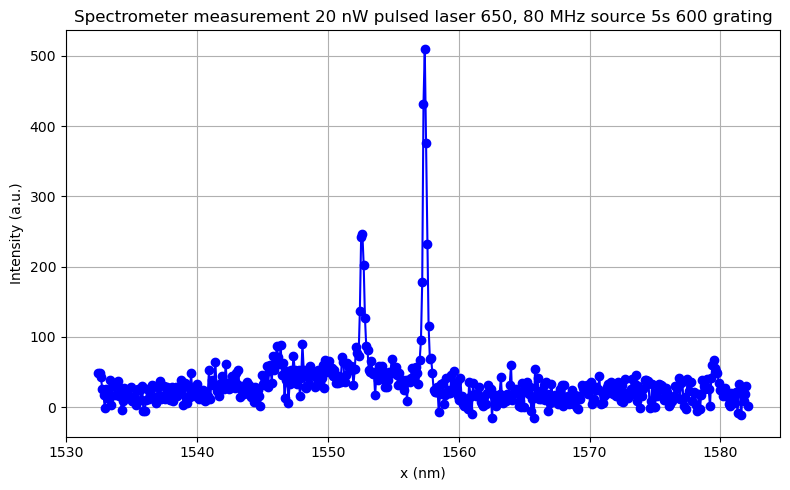

In [3]:
filename = "Spectrometer_measurement_200nW_plused_laser650_80MHz_source_5s_600_grating.asc"

data = np.loadtxt(filename)

x = data[:, 0]
y = data[:, 1]

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.title("Spectrometer measurement 20 nW pulsed laser 650, 80 MHz source 5s 600 grating")
plt.xlabel("x (nm)")
plt.ylabel("Intensity (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()

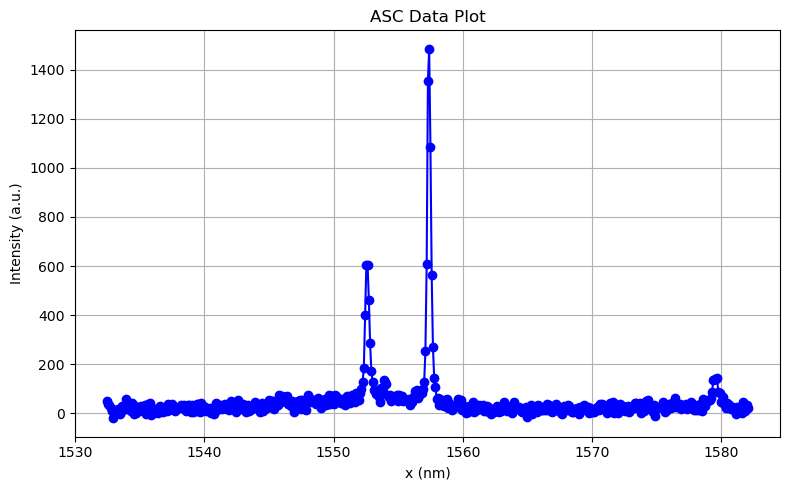

In [4]:
filename = "Spectrometer_measurement_LED_source_5s_600_grating.asc"

data = np.loadtxt(filename)
# Split into columns
x = data[:, 0]
y = data[:, 1]

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.title("ASC Data Plot")
plt.xlabel("x (nm)")
plt.ylabel("Intensity (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 0.1 Useful functions

In [5]:
def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def lorentzian(x, A, x0, gamma):
    return (A/np.pi) * (gamma / ((x - x0)**2 + gamma**2))

def get_data_in_interval(x, y, start, end):
    mask = (x >= start) & (x <= end)
    return x[mask], y[mask]

def fit_curve(function, x, y, start, end, p0):
    x_interval, y_interval = get_data_in_interval(x, y, start, end)
    popt, pcov = curve_fit(function, x_interval, y_interval, p0, maxfev = 5000)
    y_fit = function(x_interval, *popt)
    return popt, pcov, y_fit

def fit_quality_metrics(x, y, model, popt, pcov=None, sigma=None, name="model"):
    """
    Compute residuals, SSR, R2, chi2, reduced chi2, AIC, BIC, param uncertainties.
    
    Inputs:
      x, y         : data arrays (same length)
      model        : callable model(x, *popt)
      popt         : fitted parameters (array-like)
      pcov         : covariance matrix from curve_fit (or None)
      sigma        : measurement uncertainties per point (array-like or scalar) or None
      name         : string label for prints
    
    Returns:
      results dict with keys:
        residuals, ssr, r2, chi2, red_chi2, dof, aic, bic, param_errs
    """
    y_model = model(x, *popt)
    residuals = y - y_model
    ssr = np.sum(residuals**2)
    n = len(y)
    k = len(popt)
    dof = n - k
    # R^2
    ymean = np.mean(y)
    sst = np.sum((y - ymean)**2)
    r2 = 1.0 - ssr / sst if sst != 0 else np.nan

    # chi^2
    if sigma is None:
        # no measurement errors provided -> assume sigma = 1 (unweighted)
        sigma_vec = np.ones_like(y)
        note_sigma = "assumed sigma=1 for all points (unweighted)"
    else:
        sigma_vec = np.asarray(sigma)
        if sigma_vec.size == 1:
            sigma_vec = np.ones_like(y) * float(sigma_vec)
        note_sigma = "user-provided sigma"

    chi2_val = np.sum((residuals / sigma_vec)**2)
    red_chi2 = chi2_val / dof if dof > 0 else np.nan

    # AIC / BIC (using Gaussian likelihood ~ SSR)
    aic = 2 * k + n * np.log(ssr / n) if ssr > 0 else np.nan
    bic = k * np.log(n) + n * np.log(ssr / n) if ssr > 0 else np.nan

    # parameter uncertainties (if pcov available)
    if pcov is not None:
        perr = np.sqrt(np.diag(pcov))
    else:
        perr = np.array([np.nan] * k)

    # p-value of chi2
    p_value = chi2.sf(chi2_val, dof) if dof > 0 else np.nan

    results = dict(
        name=name,
        n=n,
        k=k,
        dof=dof,
        ssr=ssr,
        sst=sst,
        r2=r2,
        chi2=chi2_val,
        red_chi2=red_chi2,
        aic=aic,
        bic=bic,
        param_errs=perr,
        p_value=p_value,
        note_sigma=note_sigma,
        residuals=residuals,
        y_model=y_model,
    )
    return results

def print_fit_summary(res):
    print(f"=== Fit summary: {res['name']} ===")
    print(f"Data points: {res['n']}, Parameters: {res['k']}, DOF: {res['dof']}")
    print(f"SSR: {res['ssr']:.6g}")
    print(f"R^2: {res['r2']:.6f}")
    print(f"Chi^2: {res['chi2']:.6g}  ({res['note_sigma']})")
    print(f"Reduced Chi^2: {res['red_chi2']:.6g}")
    print(f"AIC: {res['aic']:.6g}, BIC: {res['bic']:.6g}")
    print(f"Chi^2 p-value: {res['p_value']:.6g}")
    print(f"Parameter uncertainties (1σ): {res['param_errs']}")
    print()

def plot_residuals_and_hist(x_interval, res_gauss, res_lorentz, bins=25):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax_res_g, ax_hist_g = axes[0]
    ax_res_l, ax_hist_l = axes[1]

    # Residuals vs x
    ax_res_g.scatter(x_interval, res_gauss['residuals'], s=20, alpha=0.8)
    ax_res_g.axhline(0, color='k', lw=0.8)
    ax_res_g.set_title(f"Residuals: {res_gauss['name']}")
    ax_res_g.set_xlabel("x")
    ax_res_g.set_ylabel("residual")

    ax_res_l.scatter(x_interval, res_lorentz['residuals'], s=20, alpha=0.8)
    ax_res_l.axhline(0, color='k', lw=0.8)
    ax_res_l.set_title(f"Residuals: {res_lorentz['name']}")
    ax_res_l.set_xlabel("x")
    ax_res_l.set_ylabel("residual")

    # Histograms of residuals + normal QQ (using probplot)
    ax_hist_g.hist(res_gauss['residuals'], bins=bins, density=True, alpha=0.6)
    ax_hist_g.set_title("Residual histogram (Gaussian fit)")
    ax_hist_l.hist(res_lorentz['residuals'], bins=bins, density=True, alpha=0.6)
    ax_hist_l.set_title("Residual histogram (Lorentzian fit)")

    plt.tight_layout()
    plt.show()

    # QQ-plots (separate figure)
    fig2, (aq, bq) = plt.subplots(1, 2, figsize=(10, 4))
    probplot(res_gauss['residuals'], dist="norm", plot=aq)
    aq.set_title("QQ-plot Gaussian residuals")
    probplot(res_lorentz['residuals'], dist="norm", plot=bq)
    bq.set_title("QQ-plot Lorentzian residuals")
    plt.tight_layout()
    plt.show()

## 0.2 Fitting the data to the Gaussian and Lorentzian curves

### 0.2.1 Wave interval we're going to work on

In [6]:
wavemin, wavemax = 1555, 1560  # ps

### 0.2.2 Initial guesses for Gaussian and lorentzian curves

In [7]:
A0 = y.max()
x0 = x[np.argmax(y)]
sigma0 = (x.max() - x.min()) / 20
gamma0 = sigma0

### 0.2.3 Calculating Gaussian curve parameters

In [8]:
popt_gaussian, pcov_gaussian, y_fit_gaussian = fit_curve(
        gaussian,
        x,
        y,
        wavemin,
        wavemax,
        p0=[A0, x0, sigma0]
    )

A_g, x0_g, sigma_g = popt_gaussian
fwhm_gaussian = 2.355 * sigma_g

print(f"Fit completed: \nA = {A_g:.3f}\nx₀ = {x0_g:.3f} nm\nσ = {sigma_g:.3f} nm")
print(f"FWHM = {fwhm_gaussian:.3f}")

Fit completed: 
A = 1483.326
x₀ = 1557.388 nm
σ = 0.151 nm
FWHM = 0.355


### 0.2.4 Calculating Lorentzian curve parameters

In [9]:
popt_lorentzian, pcov_lorentzian, y_fit_lorentzian = fit_curve(
        lorentzian,
        x,
        y,
        wavemin,
        wavemax,
        p0=[A0, x0, gamma0]
    )

A_l, x0_l, gamma_l = popt_lorentzian
fwhm_lorentzian = 2 * gamma_l

print(f"Fit completed: \nA = {A_l:.3f}\nx₀ = {x0_l:.3f} nm\nΓ = {gamma_l:.3f} nm")
print(f"FWHM = {fwhm_lorentzian:.3f}")

Fit completed: 
A = 742.564
x₀ = 1557.383 nm
Γ = 0.148 nm
FWHM = 0.296


## 0.3 Plottting the curves againt the data

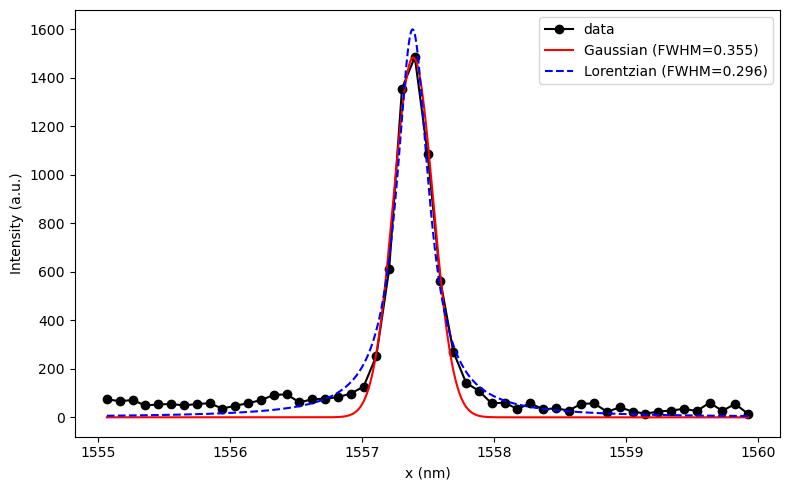

In [10]:
x_interval, y_interval= get_data_in_interval(x, y, wavemin, wavemax)
x_fit = np.linspace(x_interval[0], x_interval[-1], 1000)

plt.figure(figsize=(8,5))
plt.plot(x_interval, y_interval, marker='o', linestyle='-', color='black', label = "data")
plt.plot(x_fit, gaussian(x_fit, *popt_gaussian), 'r-', label=f'Gaussian (FWHM={fwhm_gaussian:.3f})')
plt.plot(x_fit, lorentzian(x_fit, *popt_lorentzian), 'b--', label=f'Lorentzian (FWHM={fwhm_lorentzian:.3f})')
plt.xlabel("x (nm)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

## 0.3 Calculating X^2 and residuals

=== Fit summary: Gaussian ===
Data points: 51, Parameters: 3, DOF: 48
SSR: 178156
R^2: 0.963863
Chi^2: 178156  (assumed sigma=1 for all points (unweighted))
Reduced Chi^2: 3711.58
AIC: 422.088, BIC: 427.883
Chi^2 p-value: 0
Parameter uncertainties (1σ): [4.50146987e+01 5.27788270e-03 5.27693193e-03]

=== Fit summary: Lorentzian ===
Data points: 51, Parameters: 3, DOF: 48
SSR: 106766
R^2: 0.978344
Chi^2: 106766  (assumed sigma=1 for all points (unweighted))
Reduced Chi^2: 2224.3
AIC: 395.975, BIC: 401.771
Chi^2 p-value: 0
Parameter uncertainties (1σ): [1.99718198e+01 4.02965955e-03 5.57057409e-03]



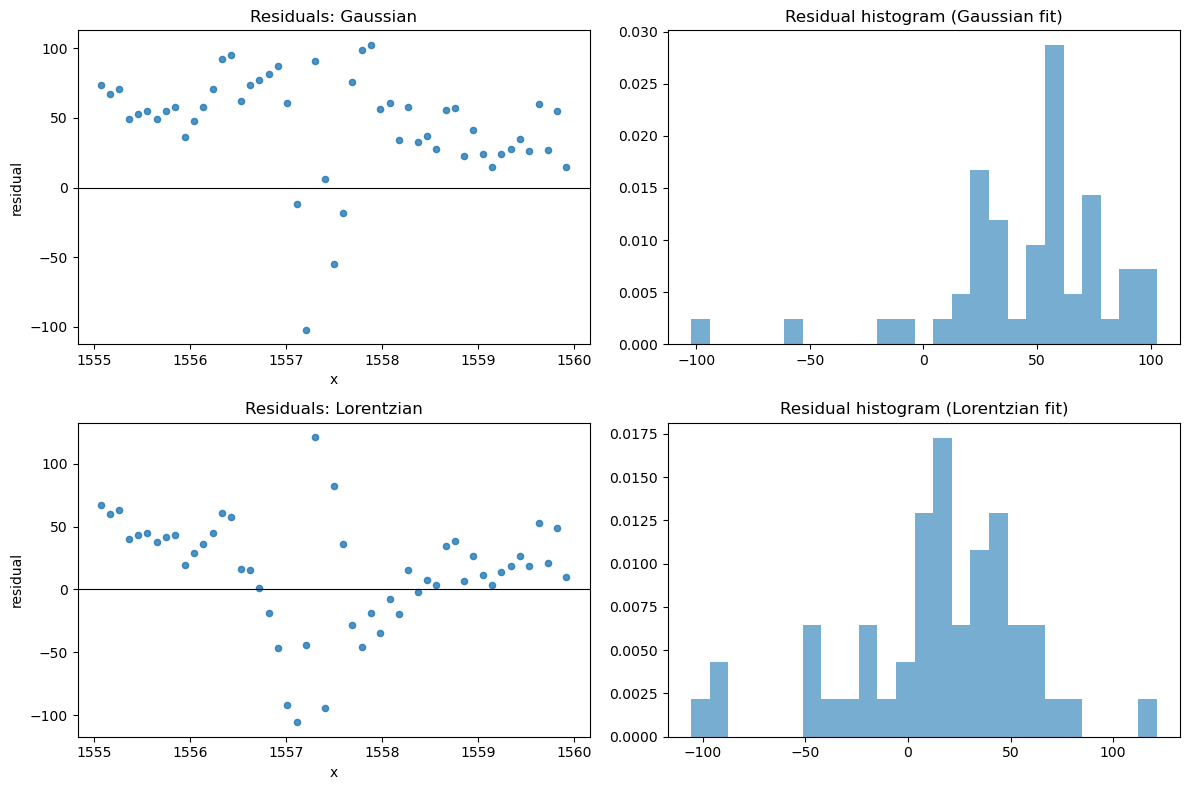

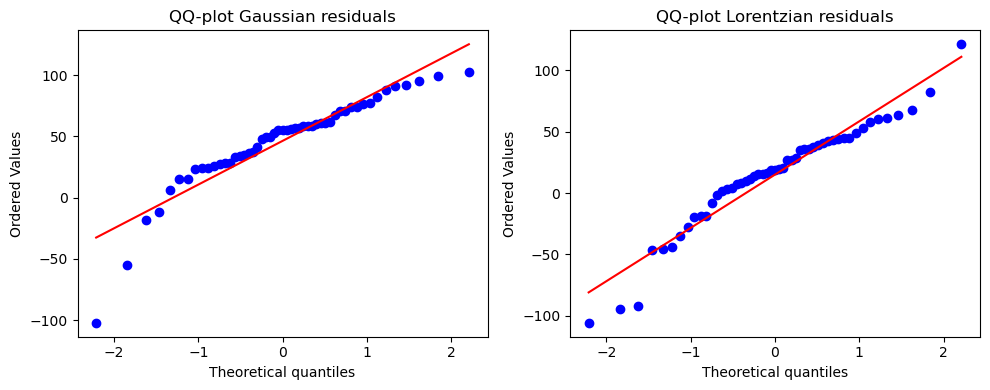

In [11]:
res_g = fit_quality_metrics(
    x=x_interval,
    y=y_interval,
    model=gaussian,
    popt=popt_gaussian,
    pcov=pcov_gaussian,   # can be None
    sigma=None,           # or sigma_array or scalar
    name="Gaussian"
)

res_l = fit_quality_metrics(
    x=x_interval,
    y=y_interval,
    model=lorentzian,
    popt=popt_lorentzian,
    pcov=pcov_lorentzian,
    sigma=None,
    name="Lorentzian"
)

print_fit_summary(res_g)
print_fit_summary(res_l)

# Plot residual diagnostics
plot_residuals_and_hist(x_interval, res_g, res_l)

# 1. Analyze the obtained photoluminescence spectra

In [12]:
file_path = "Decay_measurements_200nW_650_pulsed_80MHz_source_5s_600_grating.txt"

df = pd.read_csv(file_path, sep="\t")

time_col = "Time (ps)"
count_col = "Counts per bin"

x = df[time_col].values.astype(float)
y = df[count_col].values.astype(float)


In [13]:
def exponential_decay(t, F0, A1, t0, tau1):
    return F0 + A1 * np.exp(-(t - t0) / tau1)

In [14]:
F0 = y[0]
A1 = np.max(y)- F0
p0 = [
    F0,                          # F0_guess (baseline)
    A1,                          # A1_guess (amplitude)
    1000,                        # t0_guess (time offset)
    500                          # tau1_guess (decay constant)
]

In [15]:
peak_index = np.argmax(y)
end = np.max(x)
x_fit = x[peak_index:]
y_fit = y[peak_index:]

popt_exp, pcov_exp, y_fit_exp = fit_curve(
    exponential_decay,
    x_fit,
    y_fit,
    start = x_fit[0],
    end = x_fit[-1],
    p0=p0)

# y_fit_exp = exponential_decay(x_fit, *popt_exp)
# Unpack the best-fit parameters
F0_fit, A1_fit, t0_fit, tau1_fit = popt_exp

print("--- Best Fit Parameters ---")
print(f"F0 (Baseline):   {F0_fit:.3f}")
print(f"A1 (Amplitude):  {A1_fit:.3f}")
print(f"t0 (Time Offset): {t0_fit:.3f} (Time Units)")
print(f"tau1 (Lifetime): {tau1_fit:.3f} (Time Units)")
print("-" * 30)

--- Best Fit Parameters ---
F0 (Baseline):   7.094
A1 (Amplitude):  1576.901
t0 (Time Offset): 1245.662 (Time Units)
tau1 (Lifetime): 895.298 (Time Units)
------------------------------


## 1.1 Chi^2

=== Fit summary: Exponential decay ===
Data points: 1077, Parameters: 4, DOF: 1073
SSR: 272853
R^2: 0.991495
Chi^2: 272853  (assumed sigma=1 for all points (unweighted))
Reduced Chi^2: 254.29
AIC: 5968.93, BIC: 5988.86
Chi^2 p-value: 0
Parameter uncertainties (1σ): [5.95082101e-01 5.91044151e+08 3.35570074e+08 5.17191883e+00]



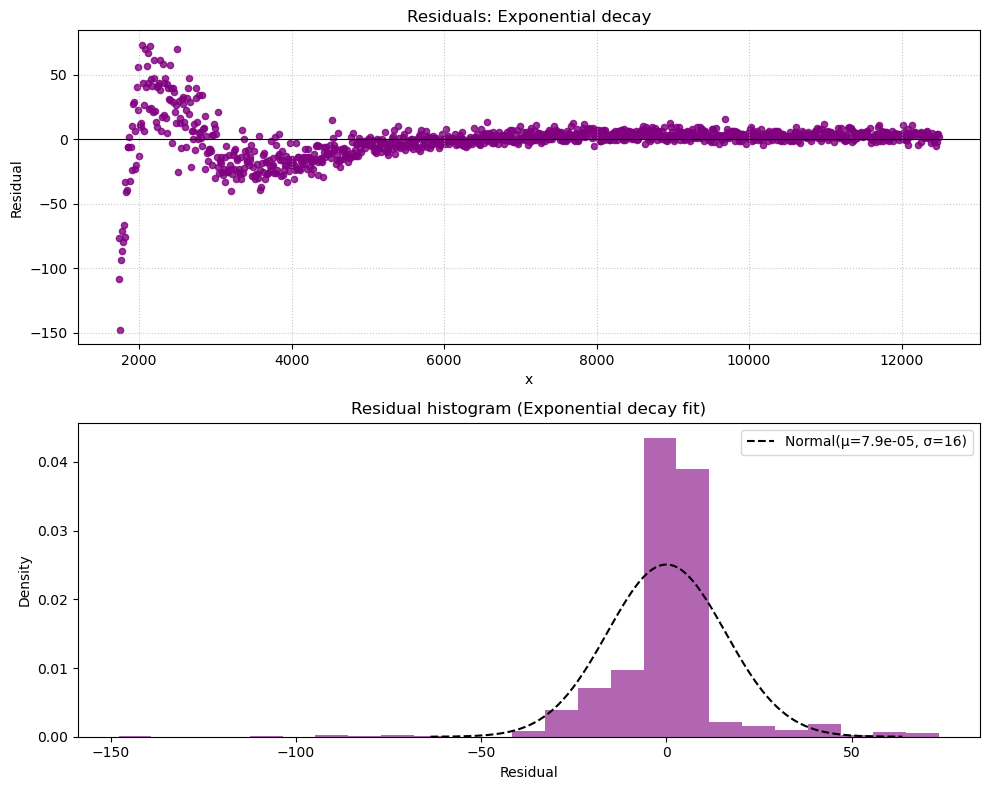

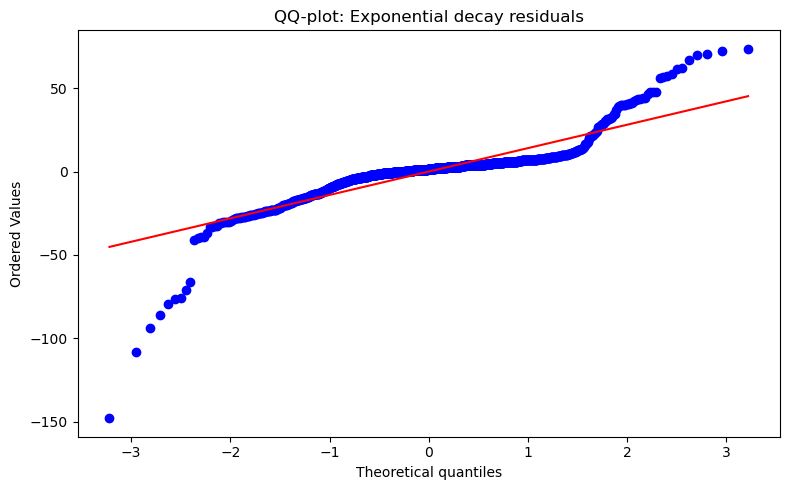

In [16]:
res_exp = fit_quality_metrics(
    x=x_fit,
    y=y_fit,
    model=exponential_decay,
    popt=popt_exp,
    pcov=pcov_exp,
    sigma=None,
    name="Exponential decay"
)

print_fit_summary(res_exp)

# Plot residual diagnostics

# --- 2×1 figure: residuals + histogram ---
fig, (ax_res, ax_hist) = plt.subplots(2, 1, figsize=(10, 8))

residuals = res_exp["residuals"]
# Residuals vs x
ax_res.scatter(x_fit, residuals, s=20, alpha=0.8, color='purple')
ax_res.axhline(0, color='k', lw=0.8)
ax_res.set_title(f"Residuals: {res_exp['name']}")
ax_res.set_xlabel("x")
ax_res.set_ylabel("Residual")
ax_res.grid(True, linestyle=':', alpha=0.7)

# Histogram of residuals
ax_hist.hist(residuals, bins=25, density=True, alpha=0.6, color='purple')

# Optional: overlay normal distribution for reference
mu, sigma = np.mean(residuals), np.std(residuals)
x_pdf = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
ax_hist.plot(x_pdf, norm.pdf(x_pdf, mu, sigma), 'k--', label=f'Normal(μ={mu:.2g}, σ={sigma:.2g})')
ax_hist.set_title("Residual histogram (Exponential decay fit)")
ax_hist.set_xlabel("Residual")
ax_hist.set_ylabel("Density")
ax_hist.legend()

plt.tight_layout()
plt.show()

# --- QQ-plot (separate figure) ---
fig_qq, ax_qq = plt.subplots(figsize=(8, 5))
probplot(residuals, dist="norm", plot=ax_qq)
ax_qq.set_title("QQ-plot: Exponential decay residuals")
plt.tight_layout()
plt.show()


## 1.2 Plotting

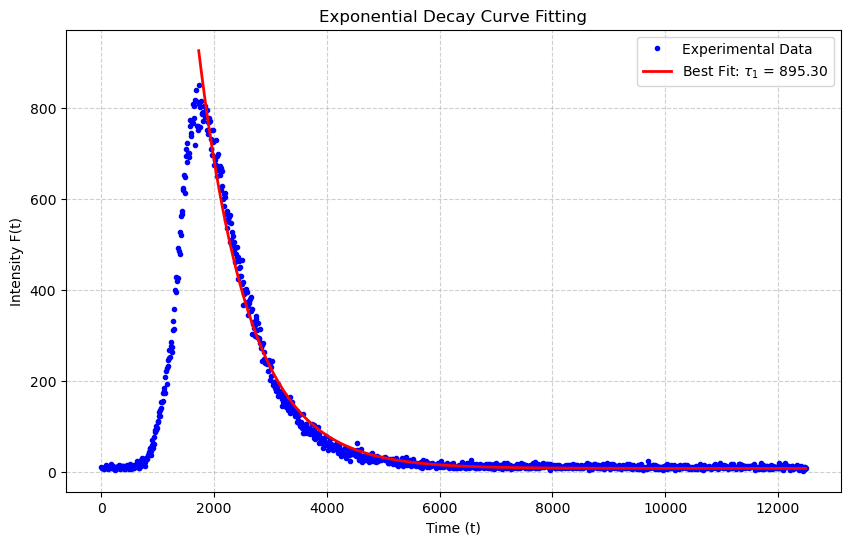

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', markersize=3, label='Experimental Data')
plt.plot(x_fit, y_fit_exp, 'r-', linewidth=2, label=f'Best Fit: $\\tau_1$ = {tau1_fit:.2f}')

plt.title('Exponential Decay Curve Fitting')
plt.xlabel('Time (t)')
plt.ylabel('Intensity F(t)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# 2. Purity (Hanbury Brown-Twiss Measurements) 

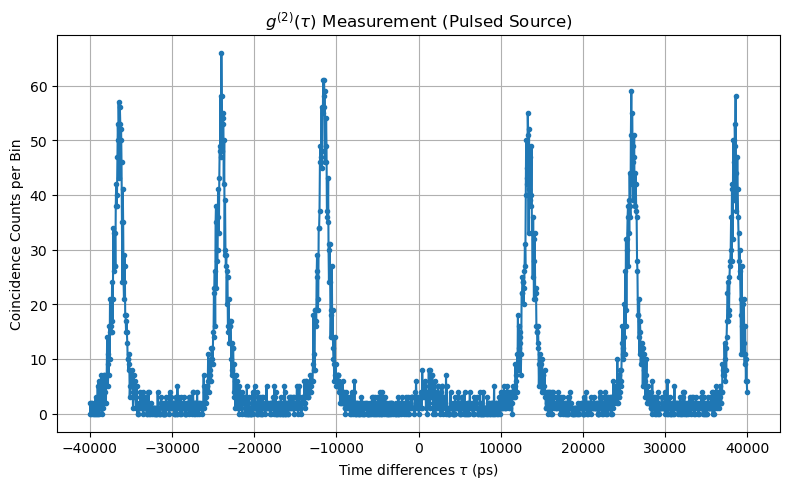

In [20]:
frequency = 80*10**6

df = pd.read_csv("HBT_measurements_200nW_650_pulsed_80MHz_source_600_grating.txt", sep="\t")
time_col = "Time differences (ps)"
count_col = "Counts per bin"

x = df[time_col].values.astype(float)
y = df[count_col].values.astype(float)

range_time = 40000

df_filtered = df[(x >= -range_time) & (x <= range_time)]
# --- 2. Plot the g^(2)(tau) measurement ---
plt.figure(figsize=(8, 5))
plt.plot(df_filtered[time_col], df_filtered[count_col], marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.title(r"$g^{(2)}(\tau)$ Measurement (Pulsed Source)")
plt.xlabel("Time differences $\\tau$ (ps)")
plt.ylabel("Coincidence Counts per Bin")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def area(df, point:int, integration_window, time_col, count_col) -> float:
    min_point = point - integration_window
    max_point = point + integration_window

    window_df = df[
        (df[time_col] >= min_point) & 
        (df[time_col] <= max_point)
    ].copy()

    x_values = window_df[time_col].values
    y_values = window_df[count_col].values
    
    integral_area = simpson(y=y_values, x=x_values)
    
    return integral_area

def average_of_side_peaks(df, frequency, integration_window, time_col, count_col, exclude_first = False, time="ps") -> float:
    x = df[time_col].values.astype(float)
    x_max = np.max(x)

    if time == "ps":
        period = (1 / frequency) * 10**12
    elif time == "ns":
        period = (1 / frequency) * 10**9

    counts = int(np.floor(x_max / period))
    areas = []
    
    if exclude_first:
        start = 2
    else:
        start = 1

    for i in range(start, counts+1):
        point = period*i
        areas.append(area(df, point, integration_window, time_col, count_col))
        areas.append(area(df, -point, integration_window, time_col, count_col))
    
    average_area = np.mean(areas)
    return average_area

## 2.1 Calculating g20

In [22]:
# then a good integration window is maybe ±1 ns around each center
integration_window = 1000
c0 = area(df, 0, integration_window, time_col, count_col)
c1 = average_of_side_peaks(df, frequency, integration_window, time_col, count_col)

g2_0 = c0 / c1
purity = 1 - g2_0

print(f"\nCoincidence Count at Zero Delay (C0): {c0:.2f}")
print(f"Average Accidental Coincidence Count (C_acc): {c1:.2f}")
print("\n----------------------------------------------------")
print(f"Calculated Second-Order Correlation Function: g^(2)(0) = {g2_0:.3f}")
print(f"Calculated Single-Photon Source Purity: Purity = {purity:.3f}")
print("----------------------------------------------------")


Coincidence Count at Zero Delay (C0): 5516.67
Average Accidental Coincidence Count (C_acc): 39554.74

----------------------------------------------------
Calculated Second-Order Correlation Function: g^(2)(0) = 0.139
Calculated Single-Photon Source Purity: Purity = 0.861
----------------------------------------------------


# 3. HOM visibility extraction Procedure

In [26]:
V_class = 1       # Classical visibility of the Mach-Zehnder
R = 0.50              # Reflectance of the beam splitter
T = 0.50              # Transmittance of the beam splitter

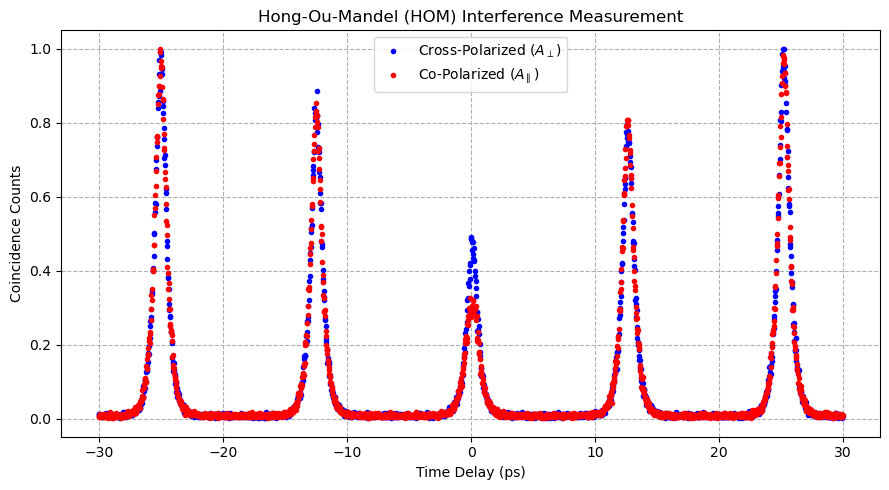

In [23]:
file_path = "HOM_co- and cros-polarization.csv"
df = pd.read_csv(file_path, skiprows=1)

# Rename columns for clarity (as provided in the prompt)
time_co = "Time_co"
coincidence_co = "Coincidence_co"
time_cross = "Time_cross"
coincidence_cross = "Coincidence_cross"

df.columns = [
    time_co, coincidence_co, "empty1", time_cross, coincidence_cross
]

# Drop the empty column
df = df.drop(columns=["empty1"])

plt.figure(figsize=(9, 5))
plt.plot(df[time_cross], df[coincidence_cross], 'o', markersize=3, label='Cross-Polarized ($A_{\perp}$)', color='blue')
plt.plot(df[time_co], df[coincidence_co], 'o', markersize=3, label='Co-Polarized ($A_{\parallel}$)', color='red')
plt.title("Hong-Ou-Mandel (HOM) Interference Measurement")
plt.xlabel("Time Delay (ps)")
plt.ylabel("Coincidence Counts")
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

In [24]:
integration_window = 1.5 # in the other one it was 1.0

co_polarization_center = area(df, 0, integration_window, time_co, coincidence_co)
co_polarization_side = average_of_side_peaks(df, frequency, integration_window, time_co, coincidence_co, exclude_first=True, time="ns")

normalized_area_co = co_polarization_center/co_polarization_side

cross_polarization_center = area(df, 0, integration_window, time_cross, coincidence_cross)
cross_polarization_side = average_of_side_peaks(df, frequency, integration_window, time_cross, coincidence_cross, exclude_first=True, time="ns")

normalized_area_cross = cross_polarization_center / cross_polarization_side

v_raw = 1- normalized_area_co / normalized_area_cross
print("-------------------------------------------------")
print(f"Normalized Co-Pol Area ($A_{{\\parallel}}$): {normalized_area_co:.5f}")
print(f"Normalized Cross-Pol Area ($A_{{\\perp}}$): {normalized_area_cross:.5f}")
print(f"Calculated Raw HOM Visibility ($V_{{Raw}}$): {v_raw:.5f}")


-------------------------------------------------
Normalized Co-Pol Area ($A_{\parallel}$): 0.38812
Normalized Cross-Pol Area ($A_{\perp}$): 0.48194
Calculated Raw HOM Visibility ($V_{Raw}$): 0.19469


In [27]:
first_component = 1 / V_class**2
second_component = 1-2*g2_0
third_component = (R**2+T**2)/(2*R*T) * v_raw

v_true = first_component * second_component * third_component

print("-------------------------------------------------")
print(f"Calculated True Single-Photon HOM Visibility ($V_{{True}}$): {v_true:.5f}")
print("-------------------------------------------------")

-------------------------------------------------
Calculated True Single-Photon HOM Visibility ($V_{True}$): 0.14038
-------------------------------------------------


In [ ]:
print("\nInterpretation:")
print(f"The raw visibility of {v_raw:.3f} is corrected to {v_true:.3f}.")
print("The $\\text{True}$ visibility represents the interference quality due to single-photon physics alone.")
print("A perfect single-photon source and setup would yield $\\mathcal{V}_{\\text{True}} = 1$ (the theoretical maximum).")